In [1]:
### Import Libraries
import networkx as nx  # For generating and analyzing graphs
import matplotlib.pyplot as plt  # For visualizations
import numpy as np  # For data manipulation
import random  # For random selections
from collections import Counter  # To get distributions easily
import scipy.stats as stats  # For fitting and analyzing distributions

In [2]:
###  Define Parameters
num_nodes = 10000  # Number of nodes in the graph
initial_degree = 5 # Initial edges per new node in Holme-Kim model
p_triangular_closure = 0.8  # Probability of triangle formation in Holme-Kim model

In [3]:
###  Generate Holme-Kim Graph
holme_kim_graph = nx.powerlaw_cluster_graph(
    n=num_nodes, m=initial_degree, p=p_triangular_closure
)


In [4]:
### Extract Degree Sequence and Generate Configuration Model
holme_kim_degree_sequence = [holme_kim_graph.degree(node) for node in holme_kim_graph.nodes]
configuration_graph = nx.configuration_model(holme_kim_degree_sequence)



In [5]:
def enforce_degree_distribution_deterministic(original_degrees, graph):
    actual_degrees = dict(graph.degree())
    nodes = sorted(graph.nodes, key=lambda n: original_degrees[n] - actual_degrees[n], reverse=True)
    
    for node in nodes:
        while actual_degrees[node] < original_degrees[node]:
            potential_nodes = [
                n for n in nodes
                if actual_degrees[n] < original_degrees[n] and n != node and not graph.has_edge(node, n)
            ]
            if not potential_nodes:
                print(f"Node {node} cannot reach target degree. Skipping...")
                break
            target_node = potential_nodes[0]  # Deterministically choose the first potential node
            graph.add_edge(node, target_node)
            actual_degrees = dict(graph.degree())
    
    return graph


In [6]:
original_degree_dict = {node: degree for node, degree in enumerate(holme_kim_degree_sequence)}
#configuration_graph = enforce_degree_distribution_deterministic(original_degree_dict, configuration_graph)  # Pontosítja a fokszámeloszlást


In [7]:
###  Define Link Randomization Function
def Link_randomise_Graph(orig_net, num_rewirings):
    _copy_net = orig_net.copy()
    _rews = 0
    while _rews < num_rewirings:
        _link_list = list(_copy_net.edges())
        _rand_edge_inds = np.random.randint(0, len(_link_list), 2)
        if _rand_edge_inds[0] != _rand_edge_inds[1]:
            _s1, _t1 = _link_list[_rand_edge_inds[0]]
            _s2, _t2 = _link_list[_rand_edge_inds[1]]
            if len(set([_s1, _t1, _s2, _t2])) == 4:
                _s1_neighs = _copy_net.neighbors(_s1)
                _s2_neighs = _copy_net.neighbors(_s2)
                if (not _t2 in _s1_neighs) and (not _t1 in _s2_neighs):
                    _copy_net.remove_edge(_s1, _t1)
                    _copy_net.remove_edge(_s2, _t2)
                    _copy_net.add_edge(_s1, _t2)
                    _copy_net.add_edge(_s2, _t1)
                    _rews += 1
    return _copy_net

In [8]:
###  Adjust Graph to Remove Loops and Parallel Edges
def adjust_graph_without_weights(graph):
    if not isinstance(graph, (nx.MultiGraph, nx.MultiDiGraph)):
        raise TypeError("Input must be a MultiGraph or MultiDiGraph.")

    original_edge_count = graph.number_of_edges()
    print(f"Original edge count: {original_edge_count}")

    simple_graph = nx.Graph()
    for u, v in graph.edges():
        if u != v:
            simple_graph.add_edge(u, v)

    simplified_edge_count = simple_graph.number_of_edges()
    removed_edges = original_edge_count - simplified_edge_count
    print(f"Removed {removed_edges} edges (loops or parallels)")

    nodes = list(simple_graph.nodes)
    added_edges = 0

    while added_edges < removed_edges:
        u, v = random.sample(nodes, 2)
        if not simple_graph.has_edge(u, v):
            simple_graph.add_edge(u, v)
            added_edges += 1

    print(f"Added {added_edges} edges to restore the original edge count.")
    return simple_graph


In [9]:
### Randomize and Adjust Configuration Graph
#configuration_graph = Link_randomise_Graph(configuration_graph, 10)
#configuration_graph = adjust_graph_without_weights(configuration_graph)



# Probability that a pair of nodes i and j are connected in the configuration model
degree_dict_conf = dict(configuration_graph.degree())                     #get degrees in config graph
M_conf = configuration_graph.number_of_edges()                             #total edges in config graph
pair_connection_probabilities = {}                                        #store connection probabilities

for i in configuration_graph.nodes():                                      #iterate over pairs (i,j)
    for j in configuration_graph.nodes():
        if j > i:                                                          #avoid double counting
            k_i = degree_dict_conf[i]                                      #degree of node i
            k_j = degree_dict_conf[j]                                      #degree of node j
            p_ij = (k_i * k_j) / (2.0 * M_conf)                            #theoretical probability of i-j connection
            pair_connection_probabilities[(i, j)] = p_ij

In [10]:
def find_loops(graph):
    """
    Find all self-loops in the graph.

    Parameters:
        graph: NetworkX Graph (or MultiGraph)
    Returns:
        List of self-loops
    """
    loops = [(u, v) for u, v in graph.edges() if u == v]
    print(f"Found {len(loops)} self-loops.")
    return loops

# Call the function
loops = find_loops(configuration_graph)
print("Self-loops:", loops)


Found 13 self-loops.
Self-loops: [(1, 1), (5, 5), (6, 6), (6, 6), (12, 12), (32, 32), (33, 33), (40, 40), (68, 68), (100, 100), (833, 833), (1796, 1796), (7266, 7266)]


In [11]:
def find_parallel_edges(graph):
    """
    Find all parallel edges in the graph.

    Parameters:
        graph: NetworkX MultiGraph
    Returns:
        Dict where keys are edge pairs and values are the count of parallel edges.
    """
    edge_counts = {}
    for u, v in graph.edges():
        edge = (u, v) if u < v else (v, u)  # Make edge undirected
        edge_counts[edge] = edge_counts.get(edge, 0) + 1

    parallel_edges = {edge: count for edge, count in edge_counts.items() if count > 1}
    print(f"Found {len(parallel_edges)} sets of parallel edges.")
    return parallel_edges

# Call the function
parallel_edges = find_parallel_edges(configuration_graph)
print("Parallel edges:", parallel_edges)


Found 263 sets of parallel edges.
Parallel edges: {(0, 6): 4, (0, 8731): 2, (0, 2788): 2, (0, 40): 2, (0, 130): 2, (0, 3350): 2, (0, 70): 2, (0, 5): 4, (0, 229): 2, (0, 34): 2, (0, 66): 2, (0, 2391): 2, (0, 33): 2, (0, 166): 2, (0, 1344): 2, (0, 3717): 2, (0, 1227): 2, (0, 7): 2, (0, 64): 2, (0, 1): 4, (0, 195): 2, (0, 366): 2, (0, 18): 2, (0, 100): 2, (0, 2451): 2, (0, 8630): 2, (0, 98): 2, (0, 1538): 2, (0, 1212): 2, (0, 3881): 2, (0, 394): 2, (1, 4230): 2, (1, 4448): 2, (1, 9): 2, (1, 67): 2, (1, 931): 2, (1, 5100): 2, (1, 33): 3, (1, 6322): 2, (1, 3): 3, (1, 6): 4, (1, 5): 3, (1, 4580): 2, (1, 1088): 2, (1, 73): 2, (1, 6215): 2, (1, 253): 2, (1, 517): 2, (1, 35): 2, (1, 5687): 2, (1, 64): 2, (1, 37): 3, (1, 290): 2, (1, 32): 2, (1, 6156): 2, (2, 226): 2, (2, 33): 2, (2, 6): 2, (2, 5): 2, (2, 100): 2, (2, 67): 2, (2, 44): 2, (3, 5): 4, (3, 32): 2, (3, 225): 2, (3, 6): 2, (3, 715): 2, (3, 8): 2, (5, 707): 2, (5, 32): 6, (5, 2059): 2, (5, 195): 3, (5, 559): 2, (5, 620): 2, (5, 1250): 

In [12]:
def preserve_degree_distribution(graph):
    """
    Remove self-loops and parallel edges while preserving the original degree distribution.

    Parameters:
        graph: NetworkX MultiGraph
            Input graph with potential self-loops and parallel edges.

    Returns:
        Graph: A simple graph with preserved degree distribution.
    """
    # Save the original degree distribution
    original_degrees = dict(graph.degree())
    
    # Step 1: Remove self-loops
    loops = find_loops(graph)
    for u, v in loops:
        graph.remove_edge(u, v)
    print(f"Removed {len(loops)} self-loops.")
    
    # Step 2: Remove parallel edges
    simple_graph = nx.Graph()
    for u, v in graph.edges():
        if not simple_graph.has_edge(u, v):  # Add edge only if it doesn't already exist
            simple_graph.add_edge(u, v)
    print(f"Removed parallel edges. Simplified edges: {simple_graph.number_of_edges()}.")

    # Step 3: Adjust to restore degree distribution
    actual_degrees = dict(simple_graph.degree())
    for node, target_degree in original_degrees.items():
        while actual_degrees[node] < target_degree:
            # Find candidate nodes to connect to
            potential_nodes = [
                n for n in simple_graph.nodes
                if actual_degrees[n] < original_degrees[n] and n != node and not simple_graph.has_edge(node, n)
            ]
            if not potential_nodes:
                print(f"Node {node} cannot reach target degree. Skipping...")
                break
            target_node = random.choice(potential_nodes)
            simple_graph.add_edge(node, target_node)
            actual_degrees = dict(simple_graph.degree())  # Update degrees after adding an edge

    return simple_graph


In [13]:
def preserve_degree_distribution_with_dummy(graph):
    """
    Remove self-loops and parallel edges while preserving the original degree distribution.

    Parameters:
        graph: NetworkX MultiGraph
            Input graph with potential self-loops and parallel edges.

    Returns:
        Graph: A simple graph with preserved degree distribution.
    """
    # Save the original degree distribution
    original_degrees = dict(graph.degree())
    
    # Step 1: Remove self-loops
    loops = find_loops(graph)
    for u, v in loops:
        graph.remove_edge(u, v)
    print(f"Removed {len(loops)} self-loops.")
    
    # Step 2: Remove parallel edges
    simple_graph = nx.Graph()
    for u, v in graph.edges():
        if not simple_graph.has_edge(u, v):  # Add edge only if it doesn't already exist
            simple_graph.add_edge(u, v)
    print(f"Removed parallel edges. Simplified edges: {simple_graph.number_of_edges()}.")

    # Step 3: Adjust to restore degree distribution
    actual_degrees = dict(simple_graph.degree())
    added_dummy_nodes = 0  # Track how many dummy nodes are added

    for node, target_degree in original_degrees.items():
        while actual_degrees[node] < target_degree:
            # Find candidate nodes to connect to
            potential_nodes = [
                n for n in simple_graph.nodes
                if actual_degrees[n] < original_degrees[n] and n != node and not simple_graph.has_edge(node, n)
            ]

            # If no potential nodes are left, add a dummy node
            if not potential_nodes:
                dummy_node = f"dummy_{added_dummy_nodes}"
                added_dummy_nodes += 1
                simple_graph.add_node(dummy_node)
                simple_graph.add_edge(node, dummy_node)
                actual_degrees = dict(simple_graph.degree())  # Update degrees after adding an edge
                continue

            # Connect to a potential node
            target_node = random.choice(potential_nodes)
            simple_graph.add_edge(node, target_node)
            actual_degrees = dict(simple_graph.degree())  # Update degrees after adding an edge

    print(f"Added {added_dummy_nodes} dummy nodes to meet target degrees.")

    # Step 4: Remove dummy nodes after restoring the degree distribution
    for dummy_node in list(simple_graph.nodes):
        if "dummy_" in str(dummy_node):
            neighbors = list(simple_graph.neighbors(dummy_node))
            if len(neighbors) > 1:
                # Reconnect neighbors directly
                for i in range(len(neighbors)):
                    for j in range(i + 1, len(neighbors)):
                        if not simple_graph.has_edge(neighbors[i], neighbors[j]):
                            simple_graph.add_edge(neighbors[i], neighbors[j])
            simple_graph.remove_node(dummy_node)

    print(f"Removed all dummy nodes. Final edges: {simple_graph.number_of_edges()}.")
    return simple_graph


Removed 13 self-loops.
Removed parallel edges. Simplified edges: 49654.


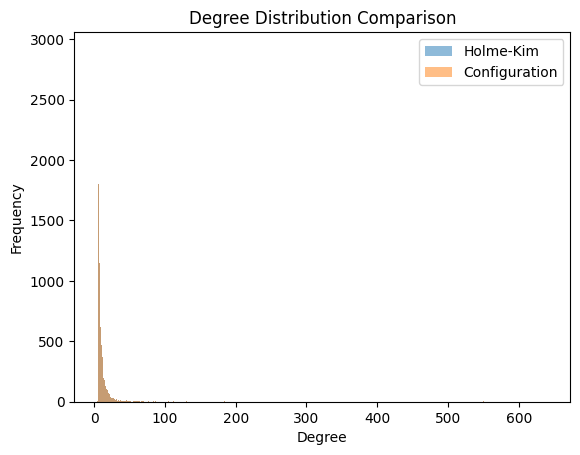

In [14]:
import networkx as nx
import random
import matplotlib.pyplot as plt

def preserve_degree_distribution_refined(graph):
    """
    Convert a multigraph to a simple graph while preserving the degree distribution.
    This version enforces degree restoration more rigorously.

    Parameters:
        graph: NetworkX MultiGraph
            Input multigraph.

    Returns:
        Graph: A simple graph with preserved degree distribution.
    """
    # Save the original degree distribution
    original_degrees = dict(graph.degree())
    
    # Step 1: Remove self-loops
    loops = list(nx.selfloop_edges(graph))
    graph.remove_edges_from(loops)
    print(f"Removed {len(loops)} self-loops.")
    
    # Step 2: Remove parallel edges
    simple_graph = nx.Graph()
    simple_graph.add_edges_from(set(graph.edges()))  # Add unique edges
    print(f"Removed parallel edges. Simplified edges: {simple_graph.number_of_edges()}.")

    # Step 3: Adjust edges to restore degree distribution
    actual_degrees = dict(simple_graph.degree())
    while True:
        # Identify nodes with unmet degree requirements
        under_connected_nodes = [n for n in simple_graph.nodes if actual_degrees[n] < original_degrees[n]]

        if not under_connected_nodes:
            # All nodes meet the original degree requirements
            break
        
        # Sort by degree deficit (highest priority to nodes with the largest gap)
        under_connected_nodes.sort(key=lambda x: original_degrees[x] - actual_degrees[x], reverse=True)
        source_node = under_connected_nodes[0]  # Node with the highest degree deficit
        
        # Find a valid target node
        target_nodes = [
            n for n in simple_graph.nodes
            if n != source_node and not simple_graph.has_edge(source_node, n) and actual_degrees[n] < original_degrees[n]
        ]
        
        if not target_nodes:
            print(f"Node {source_node} cannot fully restore its degree. Skipping...")
            break

        # Add edge to the target node with the highest deficit
        target_node = max(target_nodes, key=lambda x: original_degrees[x] - actual_degrees[x])
        simple_graph.add_edge(source_node, target_node)

        # Update degrees after adding the edge
        actual_degrees = dict(simple_graph.degree())

    return simple_graph

# Step 4: Compare Degree Distributions
def compare_degree_distributions(original_graph, cleaned_graph):
    """
    Compare degree distributions between original and cleaned graphs.

    Parameters:
        original_graph: NetworkX Graph
            The original multigraph.
        cleaned_graph: NetworkX Graph
            The resulting simple graph.
    """
    original_degrees = [d for _, d in original_graph.degree()]
    cleaned_degrees = [d for _, d in cleaned_graph.degree()]
    
    # Plot histograms
    plt.hist(original_degrees, bins=range(min(original_degrees), max(original_degrees) + 1), alpha=0.5, label="Holme-Kim")
    plt.hist(cleaned_degrees, bins=range(min(cleaned_degrees), max(cleaned_degrees) + 1), alpha=0.5, label="Configuration")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.title("Degree Distribution Comparison")
    plt.legend()
    plt.show()



configuration_graph = Link_randomise_Graph(configuration_graph, 100)



# Convert to simple graph
configuration_graph = preserve_degree_distribution_refined(configuration_graph)

# Compare degree distributions
compare_degree_distributions(holme_kim_graph, configuration_graph)

Found 0 self-loops.
Removed 0 self-loops.
Removed parallel edges. Simplified edges: 49962.
Found 0 self-loops.
Removed 0 self-loops.
Removed parallel edges. Simplified edges: 49962.
Added 0 dummy nodes to meet target degrees.
Removed all dummy nodes. Final edges: 49962.


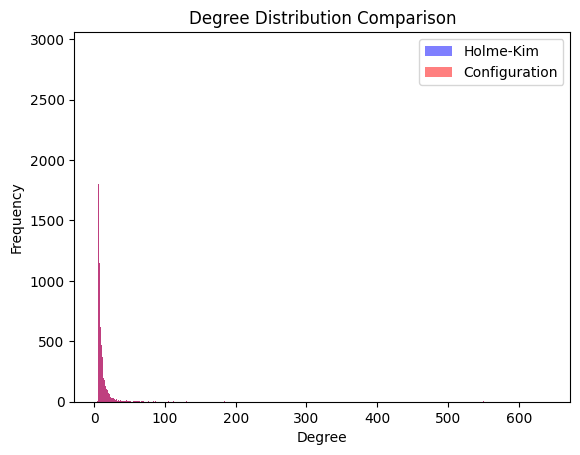

In [15]:
# Step 1: Generate the configuration model with potential loops and parallel edges
#configuration_graph = nx.configuration_model(holme_kim_degree_sequence)


# Step 2: Preserve degree distribution while cleaning the graph
configuration_graph = preserve_degree_distribution(configuration_graph)


configuration_graph = preserve_degree_distribution_with_dummy(configuration_graph)



# Step 3: Compare the degree distributions before and after
def compare_degree_distributions(original_graph, cleaned_graph):
    original_degrees = [d for _, d in original_graph.degree()]
    cleaned_degrees = [d for _, d in cleaned_graph.degree()]
    
    plt.hist(original_degrees, bins=range(min(original_degrees), max(original_degrees) + 1), alpha=0.5, label="Holme-Kim", color="blue")
    plt.hist(cleaned_degrees, bins=range(min(cleaned_degrees), max(cleaned_degrees) + 1), alpha=0.5, label="Configuration", color="red")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.title("Degree Distribution Comparison")
    plt.legend()
    plt.show()
    
#configuration_graph = enforce_degree_distribution_deterministic(original_degree_dict, configuration_graph)  # Pontosítja a fokszámeloszlást
#configuration_graph = adjust_graph_without_weights(configuration_graph)
#G_simple = nx.Graph()  # Create an empty simple graph
#G_simple.add_edges_from(configuration_graph.edges())  # The MultiGraph's edges() method returns edges without duplicates


compare_degree_distributions(holme_kim_graph, configuration_graph)


In [16]:
# 3. Validate identical degree distributions
hk_degrees = sorted([d for _, d in holme_kim_graph.degree()])
conf_degrees = sorted([d for _, d in configuration_graph.degree()])

if hk_degrees == conf_degrees:
    print("Degree distributions match exactly.")
else:
    print("Degree distributions differ.")

Degree distributions match exactly.


In [17]:
###  Compute Metrics
def compute_metrics(G):
    metrics = {
        'clustering': nx.clustering(G),
        'knn': nx.average_neighbor_degree(G),
        'closeness': nx.closeness_centrality(G),
        'assortativity': nx.degree_assortativity_coefficient(G),
    }
    if nx.is_connected(G):
        metrics['avg_path_length'] = nx.average_shortest_path_length(G)
    else:
        metrics['avg_path_length'] = None
    metrics['betweenness'] = nx.betweenness_centrality(G)
    return metrics

holme_kim_metrics = compute_metrics(holme_kim_graph)
config_metrics = compute_metrics(configuration_graph)

In [18]:
# Compute degree distribution for both graphs
def compute_degree_distribution(graph):
    degrees = [d for _, d in graph.degree()]
    degree_count = Counter(degrees)
    return degree_count

# Original Holme-Kim degree distribution
hk_degree_distribution = compute_degree_distribution(holme_kim_graph)

# Configuration model degree distribution
config_degree_distribution = compute_degree_distribution(configuration_graph)



In [19]:
# Visualize Holme-Kim Graph
#plt.figure(figsize=(8, 8))                                                 #figure for Holme-Kim visualization
#nx.draw_spring(holme_kim_graph, node_size=10, node_color="blue", edge_color="gray", alpha=0.5)
#plt.title("Holme-Kim Model Visualization")
#plt.show()

# Visualize Configuration Graph
#plt.figure(figsize=(8, 8))
#nx.draw_spring(configuration_graph, node_size=10, node_color="red", edge_color="gray", alpha=0.5)
#plt.title("Configuration Model Visualization")
#plt.show()

In [20]:
def visualize_graph_with_layouts(graph, graph_label):
    # Spring layout
    plt.figure(figsize=(8, 8))
    pos_spring = nx.spring_layout(graph, seed=42)  # Spring layout positions
    nx.draw(graph, pos=pos_spring, node_size=30, node_color="blue", edge_color="gray", alpha=0.7)
    plt.title(f"{graph_label} - Spring Layout")
    plt.show()

    # Kamada-Kawai layout
    plt.figure(figsize=(8, 8))
    pos_kamada_kawai = nx.kamada_kawai_layout(graph)  # Kamada-Kawai layout positions
    nx.draw(graph, pos=pos_kamada_kawai, node_size=30, node_color="green", edge_color="gray", alpha=0.7)
    plt.title(f"{graph_label} - Kamada-Kawai Layout")
    plt.show()

# Visualize Holme-Kim Graph with different layouts
#visualize_graph_with_layouts(holme_kim_graph, "Holme-Kim Graph")

# Visualize Configuration Graph with different layouts
#visualize_graph_with_layouts(configuration_graph, "Configuration Graph")


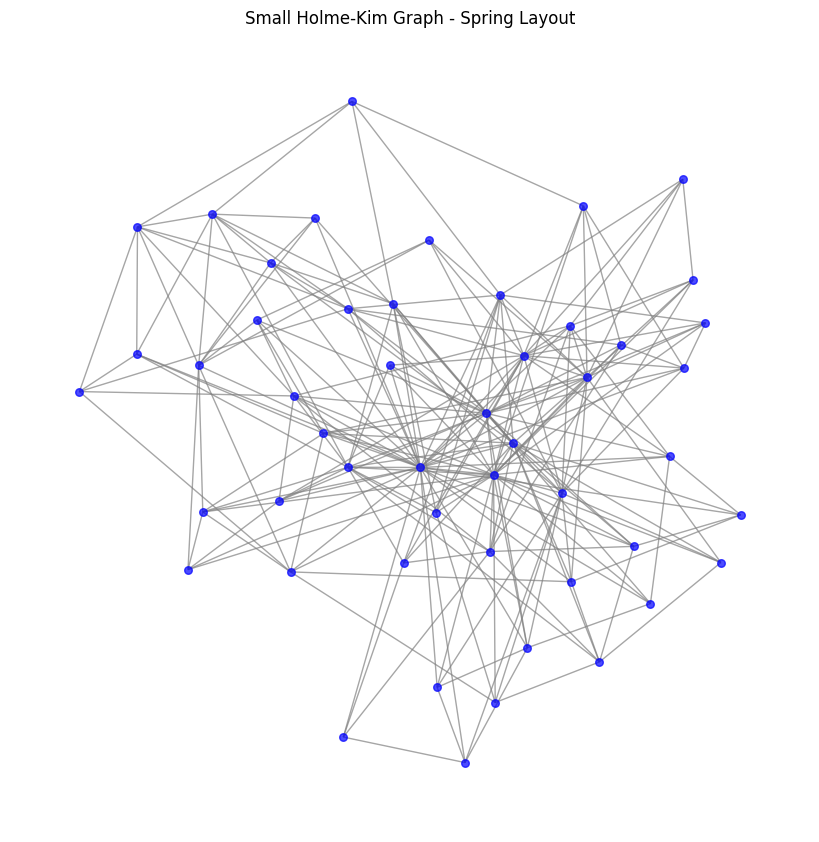

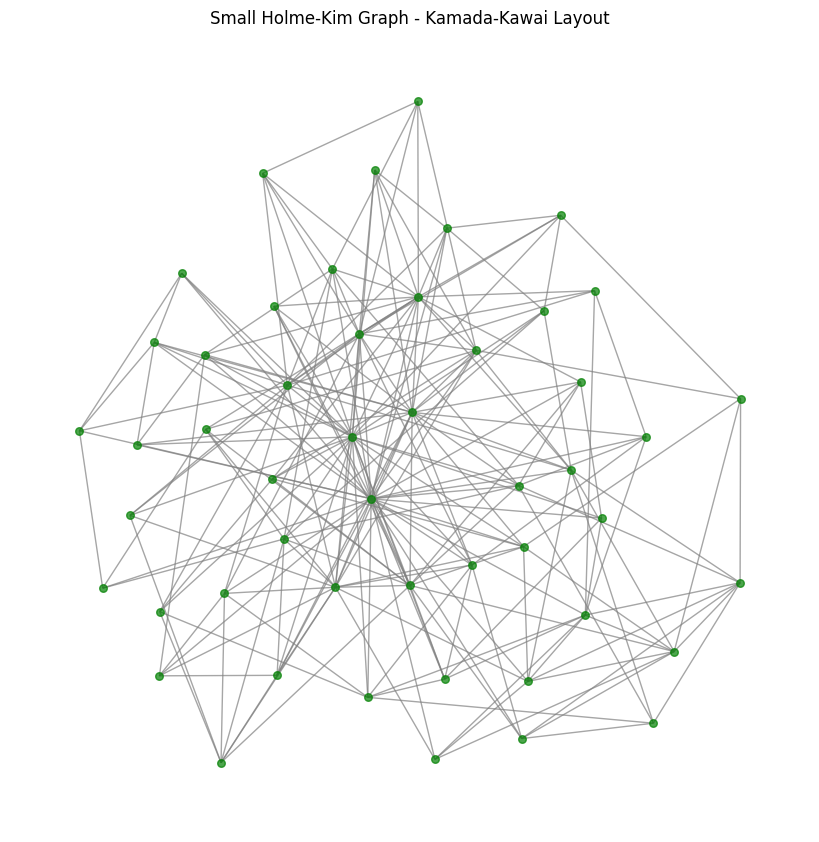

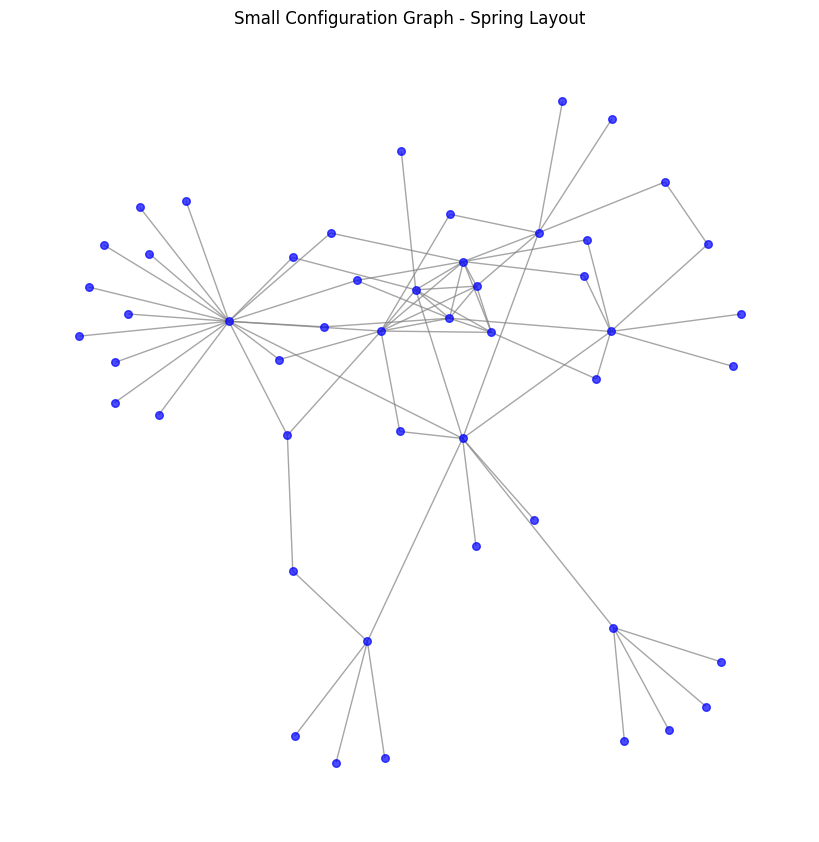

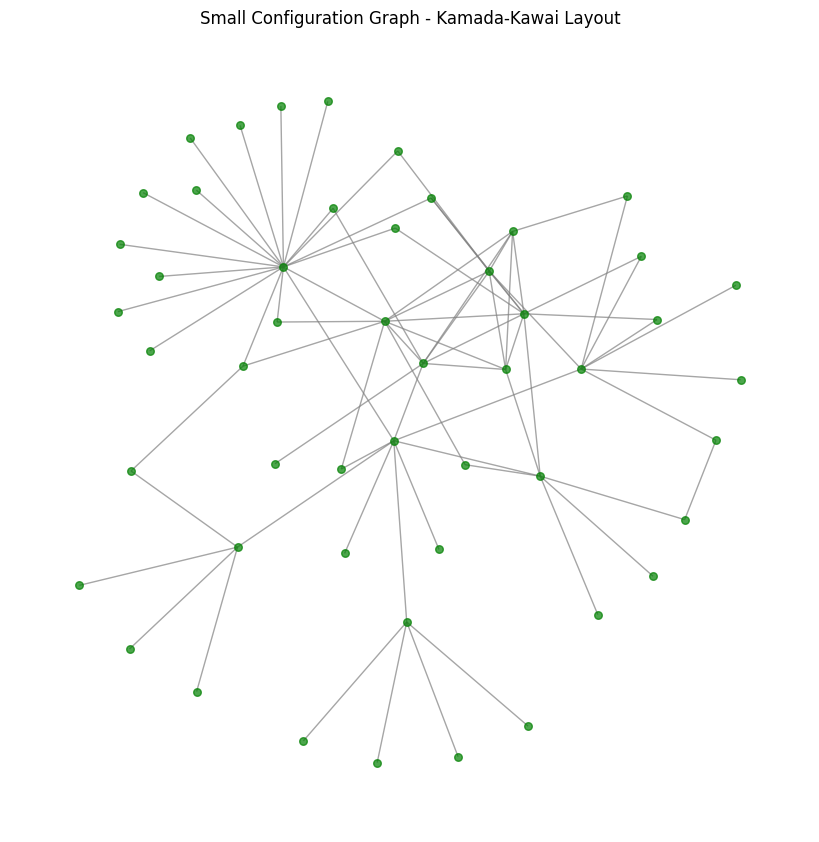

In [21]:
def extract_subgraph(graph, num_nodes):
    """
    Extracts a subgraph with the first `num_nodes` nodes.
    """
    sub_nodes = list(graph.nodes)[:num_nodes]
    subgraph = graph.subgraph(sub_nodes)
    return subgraph

# Extract small subgraphs
small_hk_graph = extract_subgraph(holme_kim_graph, 50)
small_config_graph = extract_subgraph(configuration_graph, 50)

# Visualize small subgraphs with layouts
visualize_graph_with_layouts(small_hk_graph, "Small Holme-Kim Graph")
visualize_graph_with_layouts(small_config_graph, "Small Configuration Graph")


Generating large graph layouts with subgraph visualization...


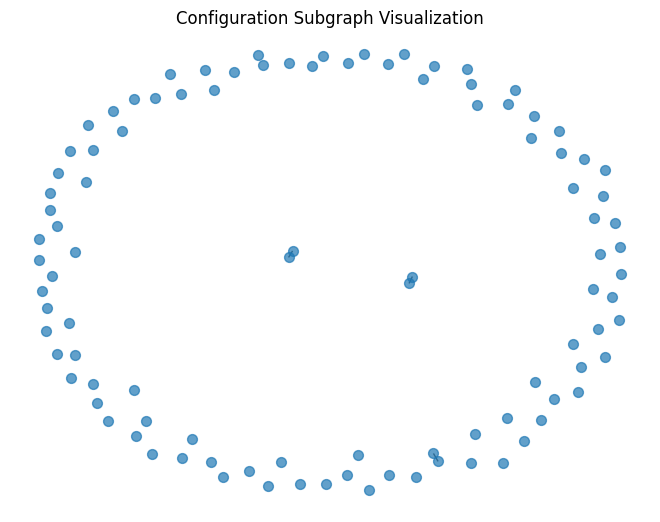

In [22]:
# Generate layout-aware visualization for large graphs
if num_nodes > 500:
    print("Generating large graph layouts with subgraph visualization...")
    subgraph = random.sample(list(configuration_graph.nodes), 100)
    hk_subgraph = configuration_graph.subgraph(subgraph)
    nx.draw(hk_subgraph, node_size=50, alpha=0.7)
    plt.title("Configuration Subgraph Visualization")
    plt.show()

Generating large graph layouts with subgraph visualization...


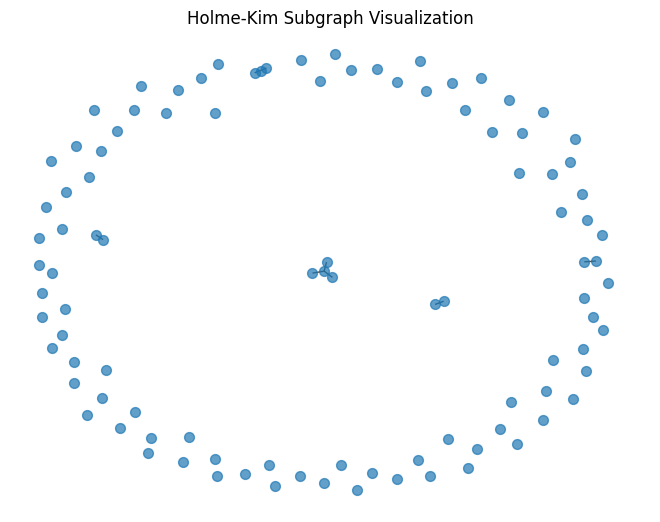

In [23]:
# Generate layout-aware visualization for large graphs
if num_nodes > 500:
    print("Generating large graph layouts with subgraph visualization...")
    subgraph = random.sample(list(holme_kim_graph.nodes), 100)
    hk_subgraph = holme_kim_graph.subgraph(subgraph)
    nx.draw(hk_subgraph, node_size=50, alpha=0.7)
    plt.title("Holme-Kim Subgraph Visualization")
    plt.show()

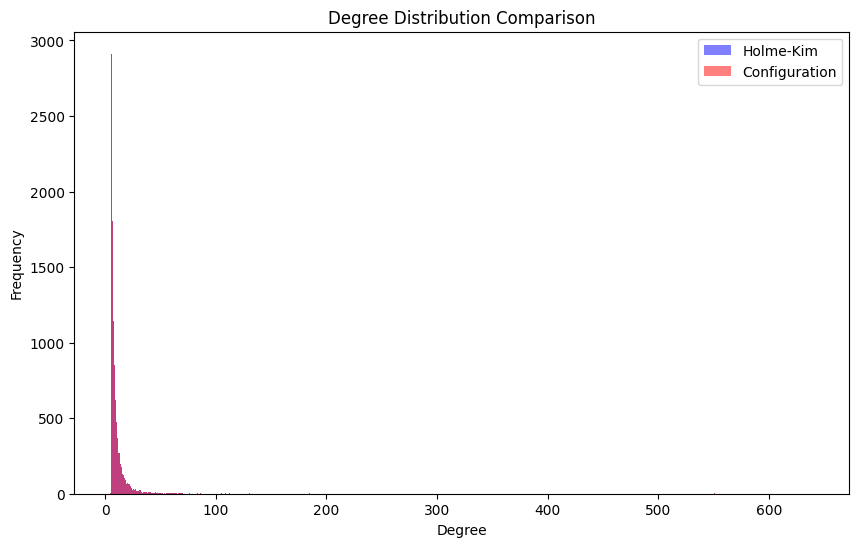

In [24]:
def compare_degree_distributions(graph1, graph2, label1, label2):
    degrees1 = [d for _, d in graph1.degree()]
    degrees2 = [d for _, d in graph2.degree()]

    plt.figure(figsize=(10, 6))
    plt.hist(degrees1, bins=range(min(degrees1), max(degrees1) + 1), alpha=0.5, label=label1, color="blue")
    plt.hist(degrees2, bins=range(min(degrees2), max(degrees2) + 1), alpha=0.5, label=label2, color="red")

    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.title("Degree Distribution Comparison")
    plt.legend()
    plt.show()

# Compare distributions of Holme-Kim and Configuration graphs
compare_degree_distributions(holme_kim_graph, configuration_graph, "Holme-Kim", "Configuration")


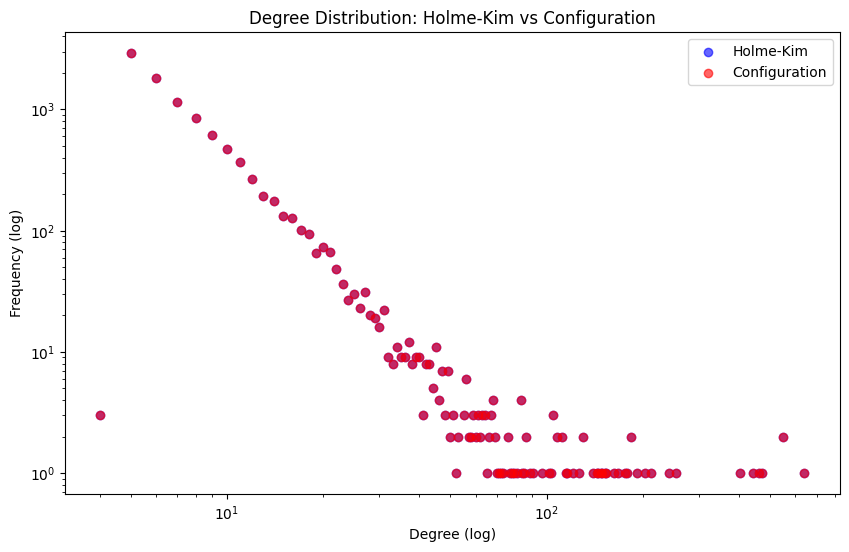

In [25]:
plt.figure(figsize=(10, 6))
for graph, label, color in zip(
    [holme_kim_graph, configuration_graph],
    ["Holme-Kim", "Configuration"],
    ["blue", "red"]):
    degrees = [d for _, d in graph.degree()]
    degree_count = Counter(degrees)
    deg, cnt = zip(*sorted(degree_count.items()))
    plt.scatter(deg, cnt, alpha=0.6, label=label, color=color)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Degree (log)")
plt.ylabel("Frequency (log)")
plt.title("Degree Distribution: Holme-Kim vs Configuration")
plt.legend()
plt.show()

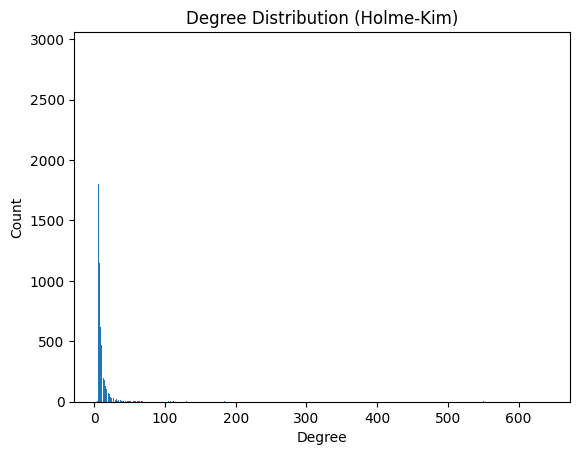

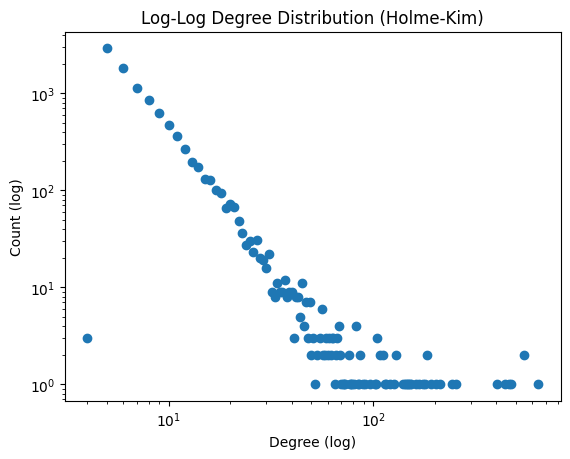

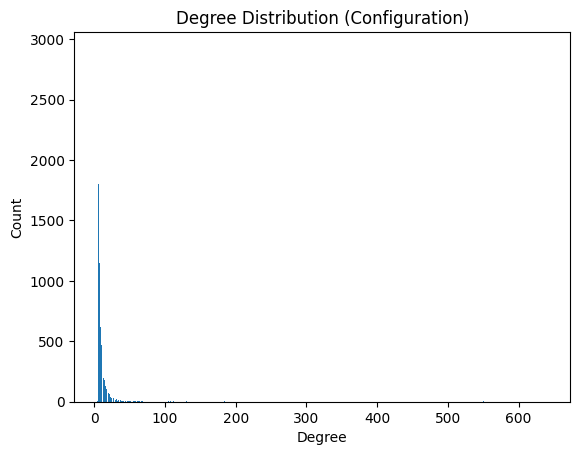

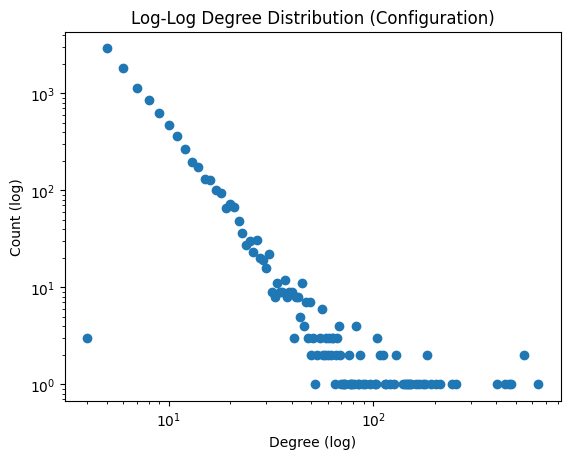

In [26]:
###  Visualizations
def plot_degree_distribution(G, graph_label):
    degrees = [d for _, d in G.degree()]
    degree_count = Counter(degrees)
    deg, cnt = zip(*sorted(degree_count.items()))
    plt.figure()
    plt.bar(deg, cnt, width=0.8)
    plt.xlabel("Degree")
    plt.ylabel("Count")
    plt.title(f"Degree Distribution ({graph_label})")
    plt.show()

    plt.figure()
    plt.loglog(deg, cnt, 'o')
    plt.xlabel("Degree (log)")
    plt.ylabel("Count (log)")
    plt.title(f"Log-Log Degree Distribution ({graph_label})")
    plt.show()



plot_degree_distribution(holme_kim_graph, "Holme-Kim")
plot_degree_distribution(configuration_graph, "Configuration")

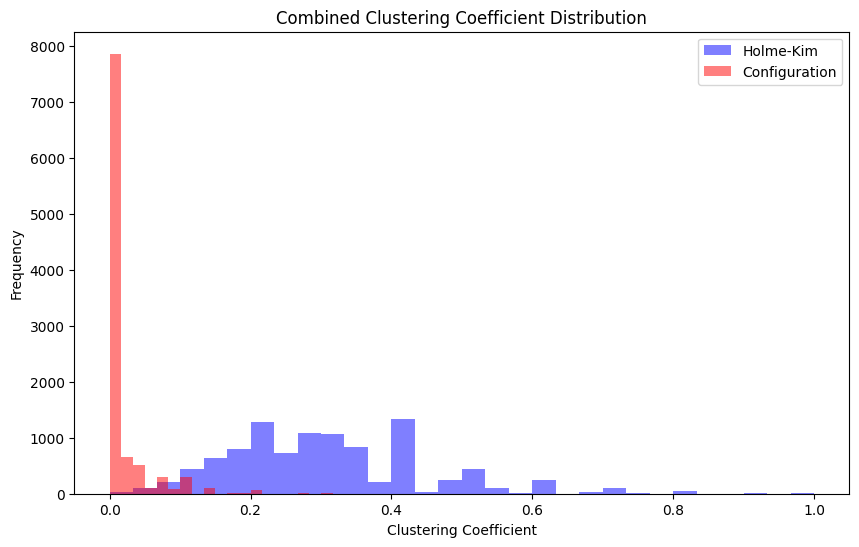

In [27]:
#  Clustering Distribution Combined Plot

def plot_combined_clustering_distribution(graph1, label1, graph2, label2):
    clustering_vals1 = list(nx.clustering(graph1).values())
    clustering_vals2 = list(nx.clustering(graph2).values())

    plt.figure(figsize=(10, 6))
    plt.hist(clustering_vals1, bins=30, alpha=0.5, label=label1, color="blue")
    plt.hist(clustering_vals2, bins=30, alpha=0.5, label=label2, color="red")
    plt.xlabel("Clustering Coefficient")
    plt.ylabel("Frequency")
    plt.title("Combined Clustering Coefficient Distribution")
    plt.legend()
    plt.show()

# Call the function for Holme-Kim and Configuration graphs
plot_combined_clustering_distribution(holme_kim_graph, "Holme-Kim", configuration_graph, "Configuration")


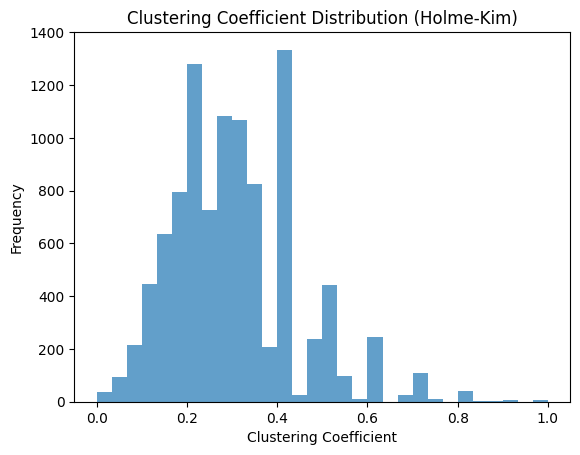

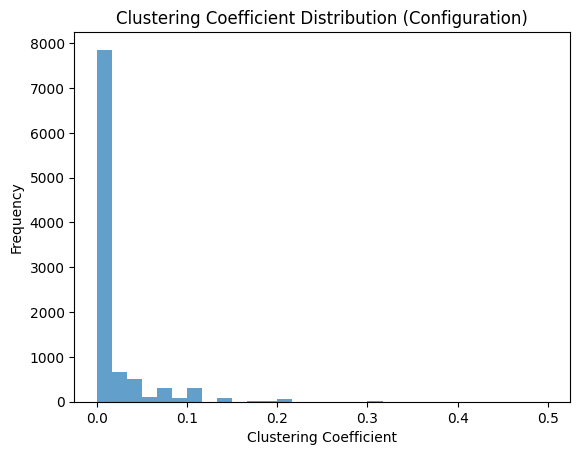

In [28]:

#  Clustering Distribution Plot
def plot_clustering_distribution(G, graph_label):
    clustering_vals = list(nx.clustering(G).values())
    plt.figure()
    plt.hist(clustering_vals, bins=30, alpha=0.7)
    plt.xlabel("Clustering Coefficient")
    plt.ylabel("Frequency")
    plt.title(f"Clustering Coefficient Distribution ({graph_label})")
    plt.show()

plot_clustering_distribution(holme_kim_graph, "Holme-Kim")
plot_clustering_distribution(configuration_graph, "Configuration")


In [29]:
def small_world_comparison(graph, label):
    """
    Compute small-world properties for a graph and its random equivalent.

    Parameters:
        graph: NetworkX graph
        label: str, label for the graph

    Returns:
        L: Average path length of the graph (or None if not computable)
        C: Average clustering coefficient of the graph
        L_rand: Average path length of a random graph (or None if not computable)
        C_rand: Average clustering coefficient of a random graph
    """
    try:
        L = nx.average_shortest_path_length(graph) if nx.is_connected(graph) else None
    except nx.NetworkXError:
        L = None
    
    C = nx.average_clustering(graph)
    
    random_graph = nx.erdos_renyi_graph(len(graph), nx.density(graph))
    try:
        L_rand = nx.average_shortest_path_length(random_graph) if nx.is_connected(random_graph) else None
    except nx.NetworkXError:
        L_rand = None
    
    C_rand = nx.average_clustering(random_graph)

    return L, C, L_rand, C_rand


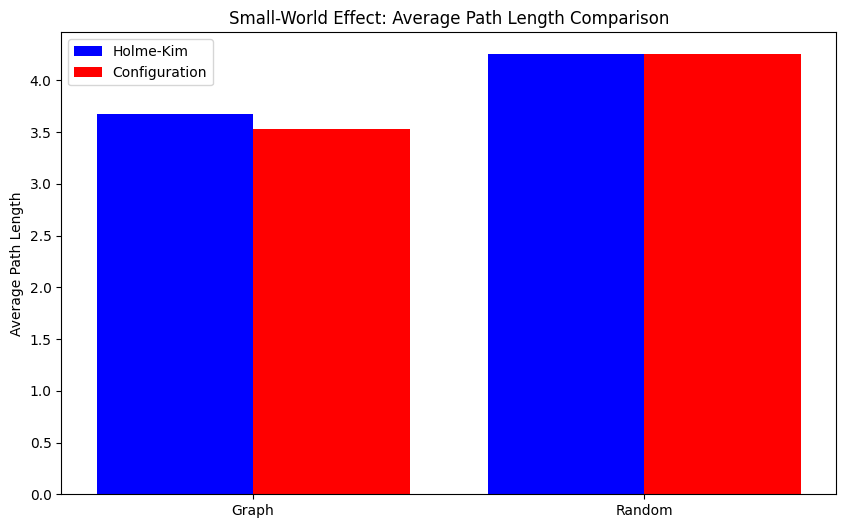

In [30]:
def plot_combined_small_world_effect(avg_path1, avg_path_rand1, avg_path2, avg_path_rand2):
    labels = ['Graph', 'Random']
    x = range(len(labels))

    plt.figure(figsize=(10, 6))
    plt.bar([i - 0.2 for i in x], [avg_path1, avg_path_rand1], width=0.4, label="Holme-Kim", color="blue")
    plt.bar([i + 0.2 for i in x], [avg_path2, avg_path_rand2], width=0.4, label="Configuration", color="red")
    plt.xticks(x, labels)
    plt.ylabel("Average Path Length")
    plt.title("Small-World Effect: Average Path Length Comparison")
    plt.legend()
    plt.show()

hk_L, hk_C, hk_L_rand, hk_C_rand = small_world_comparison(holme_kim_graph, "Holme-Kim Graph")
conf_L, conf_C, conf_L_rand, conf_C_rand = small_world_comparison(configuration_graph, "Configuration Graph")

# Assign values to the variables used in the plot
hk_avg_path_g = hk_L if hk_L is not None else 0
hk_avg_path_rand = hk_L_rand if hk_L_rand is not None else 0
conf_avg_path_g = conf_L if conf_L is not None else 0
conf_avg_path_rand = conf_L_rand if conf_L_rand is not None else 0



# Call for visualization
plot_combined_small_world_effect(hk_avg_path_g, hk_avg_path_rand, conf_avg_path_g, conf_avg_path_rand)


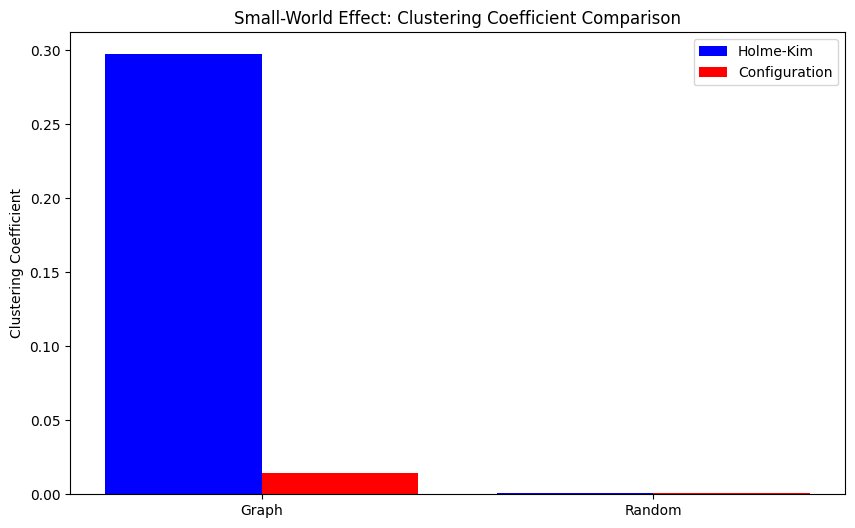

In [31]:
def plot_combined_clustering_effect(clustering1, clustering_rand1, clustering2, clustering_rand2):
    labels = ['Graph', 'Random']
    x = range(len(labels))

    plt.figure(figsize=(10, 6))
    plt.bar([i - 0.2 for i in x], [clustering1, clustering_rand1], width=0.4, label="Holme-Kim", color="blue")
    plt.bar([i + 0.2 for i in x], [clustering2, clustering_rand2], width=0.4, label="Configuration", color="red")
    plt.xticks(x, labels)
    plt.ylabel("Clustering Coefficient")
    plt.title("Small-World Effect: Clustering Coefficient Comparison")
    plt.legend()
    plt.show()



hk_L, hk_C, hk_L_rand, hk_C_rand = small_world_comparison(holme_kim_graph, "Holme-Kim Graph")
conf_L, conf_C, conf_L_rand, conf_C_rand = small_world_comparison(configuration_graph, "Configuration Graph")

# Assign clustering coefficients
hk_clustering_g = hk_C
hk_clustering_rand = hk_C_rand
conf_clustering_g = conf_C
conf_clustering_rand = conf_C_rand

plot_combined_clustering_effect(hk_clustering_g, hk_clustering_rand, conf_clustering_g, conf_clustering_rand)


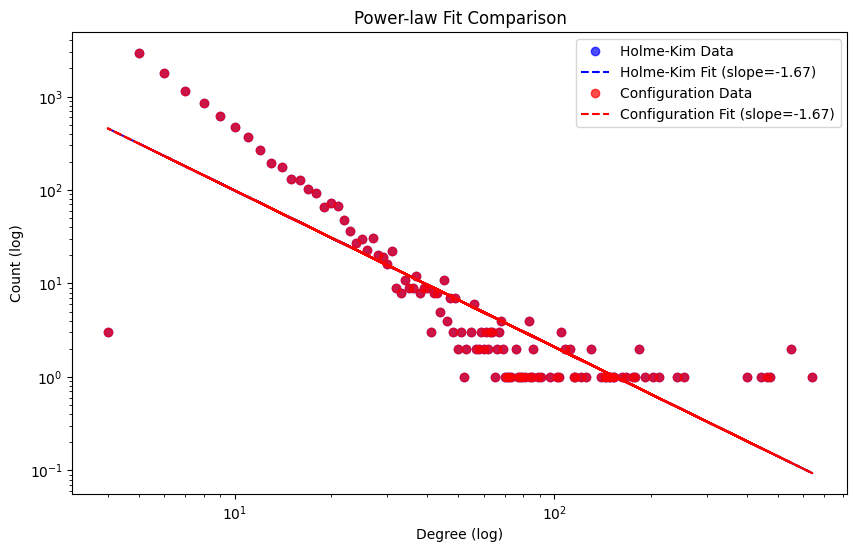

Holme-Kim Power-law Fit: slope=-1.67
Configuration Power-law Fit: slope=-1.67


In [32]:
def plot_combined_power_law_fit(graph1, label1, graph2, label2):
    """
    Compare power-law fits for two graphs on a single plot.

    Parameters:
        graph1: NetworkX graph
        label1: str, label for the first graph
        graph2: NetworkX graph
        label2: str, label for the second graph
    """
    def compute_power_law_data(G):
        degrees = np.array([d for _, d in G.degree() if d > 0])
        if len(degrees) < 2:
            print("Not enough degrees to fit power-law.")
            return None, None, None, None
        counts = Counter(degrees)
        deg, cnt = zip(*counts.items())
        deg = np.array(deg)
        cnt = np.array(cnt, dtype=float)
        x = np.log(deg)
        y = np.log(cnt)
        slope, intercept, r_value, _, _ = stats.linregress(x, y)
        return deg, cnt, slope, intercept

    # Compute power-law data for both graphs
    deg1, cnt1, slope1, intercept1 = compute_power_law_data(graph1)
    deg2, cnt2, slope2, intercept2 = compute_power_law_data(graph2)

    plt.figure(figsize=(10, 6))

    # Plot data and fits for the first graph
    plt.loglog(deg1, cnt1, 'o', alpha=0.7, label=f'{label1} Data', color='blue')
    plt.loglog(deg1, np.exp(intercept1 + slope1 * np.log(deg1)), 'b--', label=f'{label1} Fit (slope={slope1:.2f})')

    # Plot data and fits for the second graph
    plt.loglog(deg2, cnt2, 'o', alpha=0.7, label=f'{label2} Data', color='red')
    plt.loglog(deg2, np.exp(intercept2 + slope2 * np.log(deg2)), 'r--', label=f'{label2} Fit (slope={slope2:.2f})')

    plt.xlabel('Degree (log)')
    plt.ylabel('Count (log)')
    plt.title("Power-law Fit Comparison")
    plt.legend()
    plt.show()

    print(f"{label1} Power-law Fit: slope={slope1:.2f}")
    print(f"{label2} Power-law Fit: slope={slope2:.2f}")

# Call for both graphs
plot_combined_power_law_fit(holme_kim_graph, "Holme-Kim", configuration_graph, "Configuration")


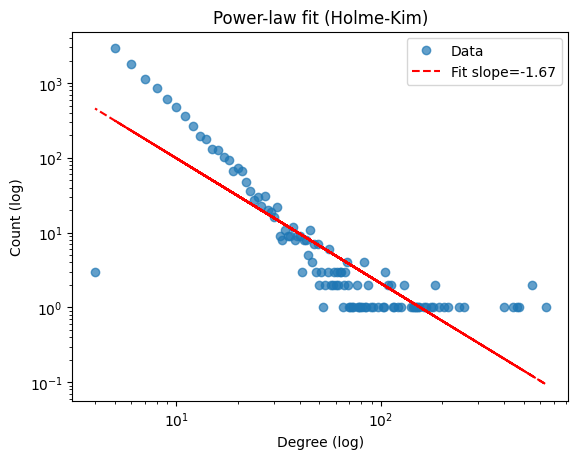

Power-law fit for Holme-Kim: slope=-1.6728398042546204, R²=0.7226611603492772


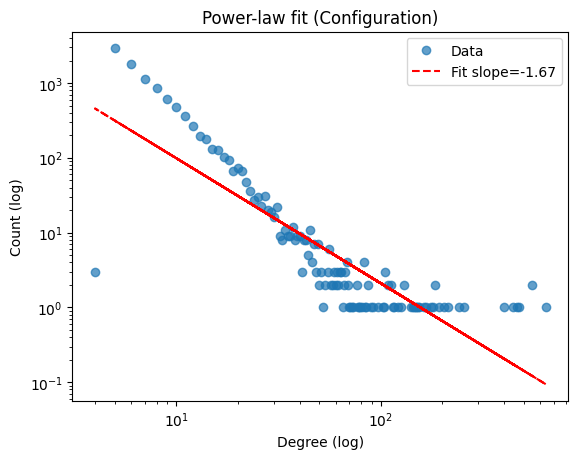

Power-law fit for Configuration: slope=-1.6728398042546215, R²=0.7226611603492782


(np.float64(-1.6728398042546215), np.float64(0.7226611603492782))

In [33]:

# Cell  Power-Law Fit
def fit_power_law(G, graph_label):
    degrees = np.array([d for _, d in G.degree() if d > 0])
    if len(degrees) < 2:
        print(f"Not enough degrees to fit power-law for {graph_label}")
        return None, None
    counts = Counter(degrees)
    deg, cnt = zip(*counts.items())
    deg = np.array(deg)
    cnt = np.array(cnt, dtype=float)

    x = np.log(deg)
    y = np.log(cnt)
    slope, intercept, r_value, _, _ = stats.linregress(x, y)

    plt.figure()
    plt.loglog(deg, cnt, 'o', alpha=0.7, label='Data')
    plt.loglog(deg, np.exp(intercept + slope * x), 'r--', label=f'Fit slope={slope:.2f}')
    plt.xlabel('Degree (log)')
    plt.ylabel('Count (log)')
    plt.title(f"Power-law fit ({graph_label})")
    plt.legend()
    plt.show()
    print(f"Power-law fit for {graph_label}: slope={slope}, R²={r_value**2}")
    return slope, r_value**2

fit_power_law(holme_kim_graph, "Holme-Kim")
fit_power_law(configuration_graph, "Configuration")

In [34]:
# Average Clustering Coefficient
def print_average_clustering_info(G, graph_label):
    c = nx.average_clustering(G)
    print(f"\n--- Clustering Info ({graph_label}) ---")
    print(f"Average Clustering Coefficient: {c:.4f}")

print_average_clustering_info(holme_kim_graph, "Holme-Kim")
print_average_clustering_info(configuration_graph, "Configuration")


--- Clustering Info (Holme-Kim) ---
Average Clustering Coefficient: 0.2972

--- Clustering Info (Configuration) ---
Average Clustering Coefficient: 0.0141


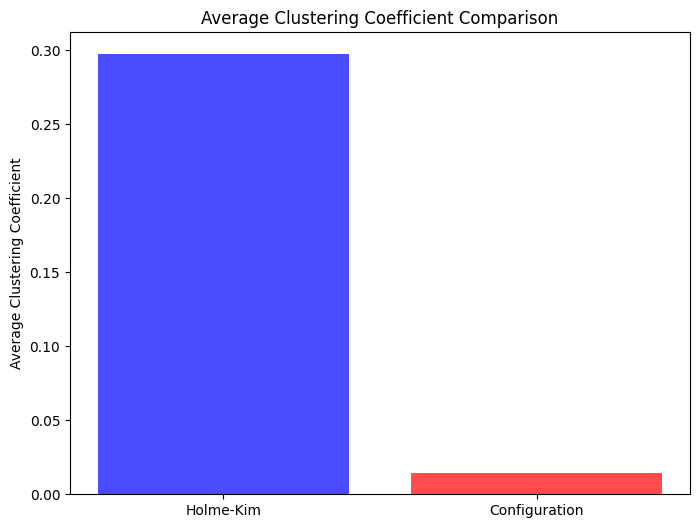

Holme-Kim Average Clustering Coefficient: 0.2972
Configuration Average Clustering Coefficient: 0.0141


In [35]:
def plot_combined_average_clustering(graph1, label1, graph2, label2):
    """
    Plot a comparison of average clustering coefficients for two graphs.

    Parameters:
        graph1: NetworkX graph
        label1: str, label for the first graph
        graph2: NetworkX graph
        label2: str, label for the second graph
    """
    # Compute average clustering coefficients
    clustering1 = nx.average_clustering(graph1)
    clustering2 = nx.average_clustering(graph2)

    # Plot the clustering coefficients
    plt.figure(figsize=(8, 6))
    plt.bar([label1, label2], [clustering1, clustering2], color=['blue', 'red'], alpha=0.7)
    plt.ylabel("Average Clustering Coefficient")
    plt.title("Average Clustering Coefficient Comparison")
    plt.show()

    # Print the results
    print(f"{label1} Average Clustering Coefficient: {clustering1:.4f}")
    print(f"{label2} Average Clustering Coefficient: {clustering2:.4f}")

# Call the function to visualize and compare
plot_combined_average_clustering(holme_kim_graph, "Holme-Kim", configuration_graph, "Configuration")


In [36]:
#  Metrics Summary
print("\nMetrics Summary:")
print("Holme-Kim Graph Assortativity:", holme_kim_metrics['assortativity'])
print("Configuration Graph Assortativity:", config_metrics['assortativity'])

print("Holme-Kim Graph Avg Path Length:", holme_kim_metrics['avg_path_length'])
print("Configuration Graph Avg Path Length:", config_metrics['avg_path_length'])


Metrics Summary:
Holme-Kim Graph Assortativity: -0.058877089312195874
Configuration Graph Assortativity: -0.01624332936222127
Holme-Kim Graph Avg Path Length: 3.679531893189319
Configuration Graph Avg Path Length: 3.5303644364436444


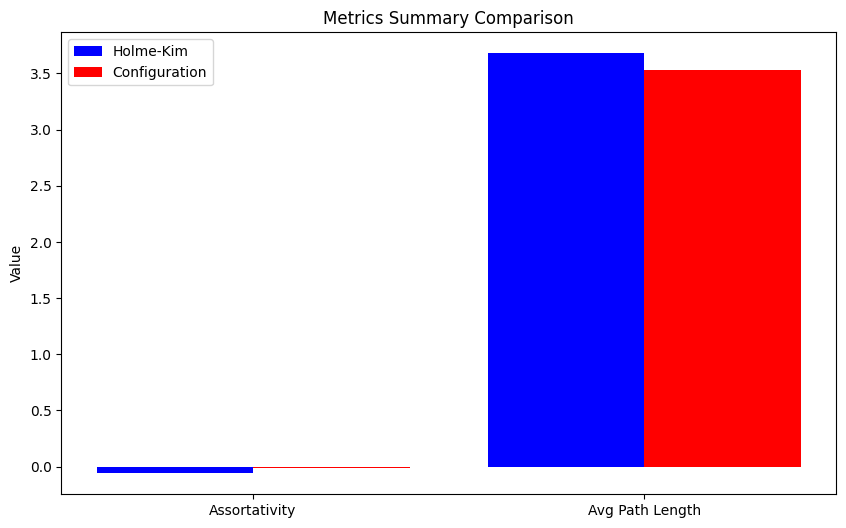

In [37]:
def plot_metrics_summary(assort1, avg_path1, label1, assort2, avg_path2, label2):
    """
    Plot a combined comparison of assortativity and average path length for two graphs.

    Parameters:
        assort1: float
            Assortativity coefficient for the first graph.
        avg_path1: float
            Average path length for the first graph.
        label1: str
            Label for the first graph.
        assort2: float
            Assortativity coefficient for the second graph.
        avg_path2: float
            Average path length for the second graph.
        label2: str
            Label for the second graph.
    """
    # Metrics for plotting
    metrics = ['Assortativity', 'Avg Path Length']
    values1 = [assort1, avg_path1]
    values2 = [assort2, avg_path2]

    # Bar plot
    x = range(len(metrics))
    plt.figure(figsize=(10, 6))
    plt.bar([i - 0.2 for i in x], values1, width=0.4, label=label1, color='blue')
    plt.bar([i + 0.2 for i in x], values2, width=0.4, label=label2, color='red')
    plt.xticks(x, metrics)
    plt.ylabel("Value")
    plt.title("Metrics Summary Comparison")
    plt.legend()
    plt.show()

# Extract metrics for Holme-Kim and Configuration graphs
holme_kim_assort = holme_kim_metrics['assortativity']
holme_kim_avg_path = holme_kim_metrics['avg_path_length']
config_assort = config_metrics['assortativity']
config_avg_path = config_metrics['avg_path_length']

# Call the function to plot
plot_metrics_summary(
    holme_kim_assort, holme_kim_avg_path, "Holme-Kim",
    config_assort, config_avg_path, "Configuration"
)


In [38]:
#  Node-Level Metrics Correlation Plots
def get_node_metrics(G):
    degrees = np.array([d for _, d in G.degree()])
    nodes = list(G.nodes())
    clustering_values = np.array([nx.clustering(G, n) for n in nodes])
    knn_dict = nx.average_neighbor_degree(G)
    knn_values = np.array([knn_dict[n] for n in nodes])
    return degrees, clustering_values, knn_values

holme_kim_degrees, holme_kim_clustering_values, holme_kim_knn_values = get_node_metrics(holme_kim_graph)
config_degrees, config_clustering_values, config_knn_values = get_node_metrics(configuration_graph)


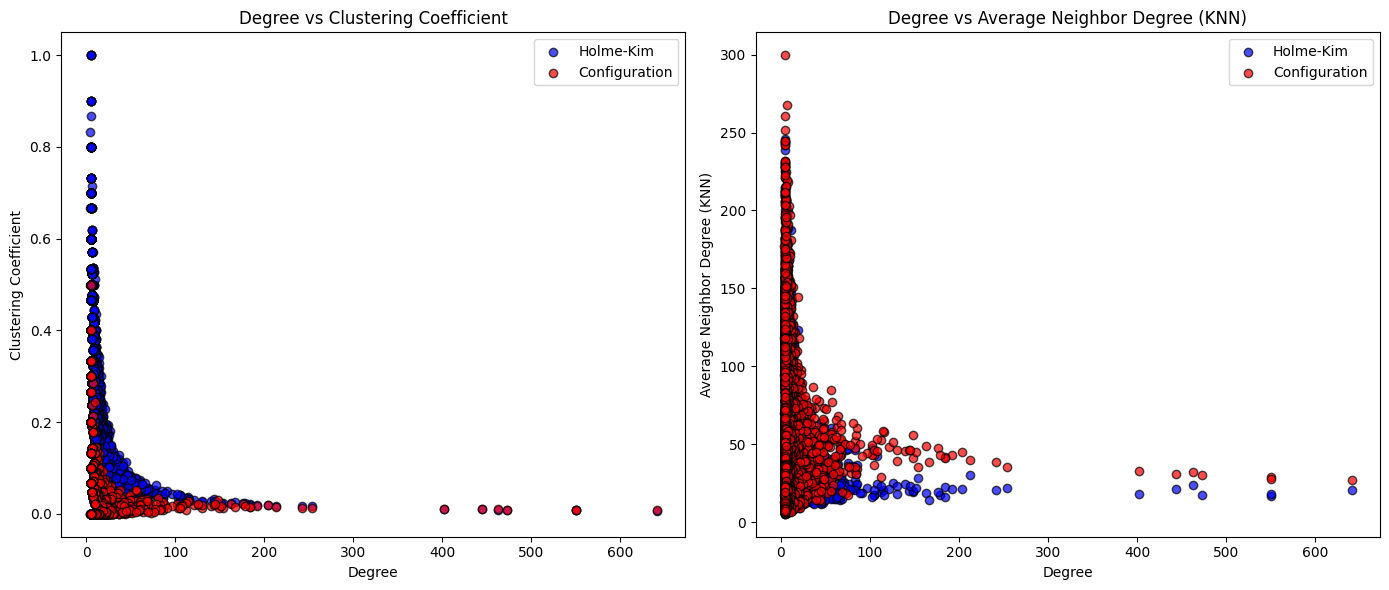

In [39]:
def plot_combined_node_metrics(degrees1, clustering1, knn1, label1,
                               degrees2, clustering2, knn2, label2):
    """
    Plot combined node-level metrics (Degree vs Clustering, Degree vs KNN) for two graphs.

    Parameters:
        degrees1: array
            Degrees of nodes in the first graph.
        clustering1: array
            Clustering coefficients for the first graph.
        knn1: array
            Average neighbor degree (KNN) for the first graph.
        label1: str
            Label for the first graph.
        degrees2: array
            Degrees of nodes in the second graph.
        clustering2: array
            Clustering coefficients for the second graph.
        knn2: array
            Average neighbor degree (KNN) for the second graph.
        label2: str
            Label for the second graph.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Plot Degree vs Clustering Coefficient
    axes[0].scatter(degrees1, clustering1, alpha=0.7, label=label1, edgecolors='k', color='blue')
    axes[0].scatter(degrees2, clustering2, alpha=0.7, label=label2, edgecolors='k', color='red')
    axes[0].set_xlabel("Degree")
    axes[0].set_ylabel("Clustering Coefficient")
    axes[0].set_title("Degree vs Clustering Coefficient")
    axes[0].legend()

    # Plot Degree vs Average Neighbor Degree (KNN)
    axes[1].scatter(degrees1, knn1, alpha=0.7, label=label1, edgecolors='k', color='blue')
    axes[1].scatter(degrees2, knn2, alpha=0.7, label=label2, edgecolors='k', color='red')
    axes[1].set_xlabel("Degree")
    axes[1].set_ylabel("Average Neighbor Degree (KNN)")
    axes[1].set_title("Degree vs Average Neighbor Degree (KNN)")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot the combined metrics
plot_combined_node_metrics(
    holme_kim_degrees, holme_kim_clustering_values, holme_kim_knn_values, "Holme-Kim",
    config_degrees, config_clustering_values, config_knn_values, "Configuration"
)


In [40]:
#  Metric vs Degree Plots
def plot_metric_vs_degree(deg_array, metric_array, graph_label, metric_name, loglog=False):
    plt.figure(figsize=(7, 5))
    valid_idx = (deg_array > 0) & (metric_array > 0)
    deg_filtered = deg_array[valid_idx]
    metric_filtered = metric_array[valid_idx]

    plt.scatter(deg_filtered, metric_filtered, alpha=0.7, edgecolor='k', label='Data')

    if loglog:
        plt.xscale('log')
        plt.yscale('log')
        x_log = np.log(deg_filtered)
        y_log = np.log(metric_filtered)
        if len(x_log) > 2:
            slope, intercept, r_value, _, _ = stats.linregress(x_log, y_log)
            fit_line = np.exp(intercept + slope * x_log)
            plt.plot(deg_filtered, fit_line, 'r--', label=f'Fit slope={slope:.2f}, R²={r_value**2:.2f}')

    plt.xlabel("Degree")
    plt.ylabel(metric_name)
    plt.title(f"{metric_name} vs Degree ({graph_label})")
    plt.grid(True)
    plt.legend()
    plt.show()

In [41]:
def plot_combined_metrics_vs_degree(degrees1, metric1, label1, metric_name,
                                    degrees2, metric2, label2, loglog=False):
    """
    Plot combined metric vs degree for two graphs.

    Parameters:
        degrees1: array
            Degrees for the first graph.
        metric1: array
            Metric values for the first graph.
        label1: str
            Label for the first graph.
        metric_name: str
            Name of the metric being plotted.
        degrees2: array
            Degrees for the second graph.
        metric2: array
            Metric values for the second graph.
        label2: str
            Label for the second graph.
        loglog: bool
            If True, use log-log scale.
    """
    plt.figure(figsize=(10, 6))
    
    # Filter valid indices where degree and metric are greater than zero
    valid_idx1 = (degrees1 > 0) & (metric1 > 0)
    valid_idx2 = (degrees2 > 0) & (metric2 > 0)
    
    degrees1_filtered = degrees1[valid_idx1]
    metric1_filtered = metric1[valid_idx1]
    degrees2_filtered = degrees2[valid_idx2]
    metric2_filtered = metric2[valid_idx2]

    # Plot data points
    plt.scatter(degrees1_filtered, metric1_filtered, alpha=0.7, edgecolor='k', label=label1, color='blue')
    plt.scatter(degrees2_filtered, metric2_filtered, alpha=0.7, edgecolor='k', label=label2, color='red')

    # Apply log-log scale if specified
    if loglog:
        plt.xscale('log')
        plt.yscale('log')

    # Add labels, title, and legend
    plt.xlabel("Degree")
    plt.ylabel(metric_name)
    scale_type = "Log-Log" if loglog else "Linear"
    plt.title(f"{metric_name} vs Degree ({scale_type} Scale)")
    plt.legend()
    plt.grid(True)
    plt.show()

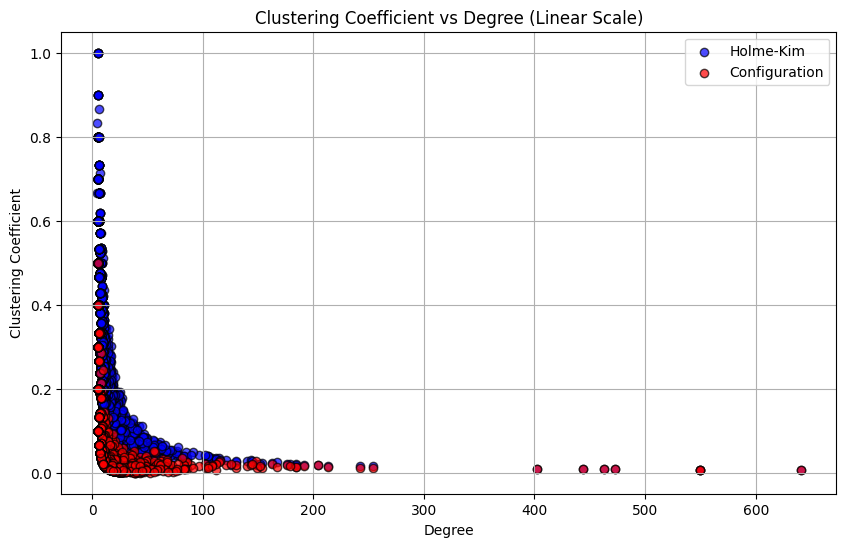

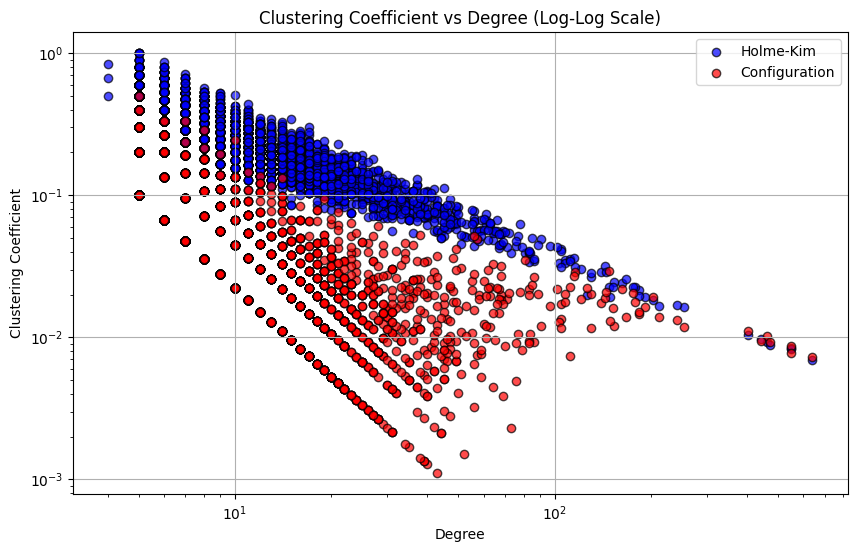

In [42]:
# Plot Clustering Coefficient vs Degree
plot_combined_metrics_vs_degree(
    holme_kim_degrees, holme_kim_clustering_values, "Holme-Kim",
    "Clustering Coefficient",
    config_degrees, config_clustering_values, "Configuration",
    loglog=False
)

plot_combined_metrics_vs_degree(
    holme_kim_degrees, holme_kim_clustering_values, "Holme-Kim",
    "Clustering Coefficient",
    config_degrees, config_clustering_values, "Configuration",
    loglog=True
)

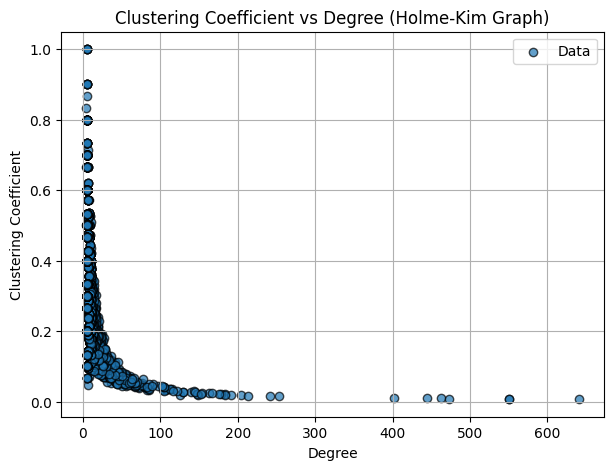

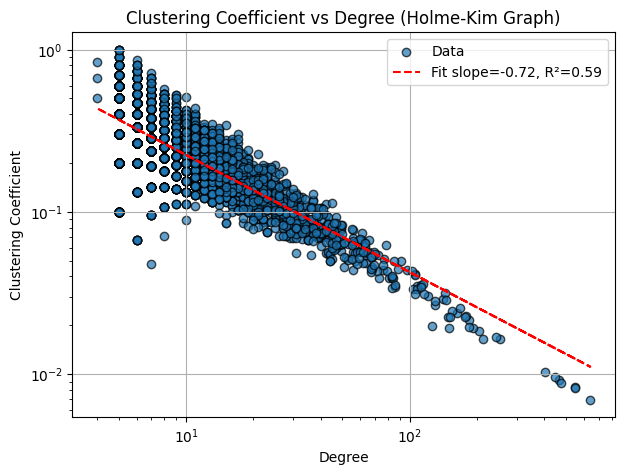

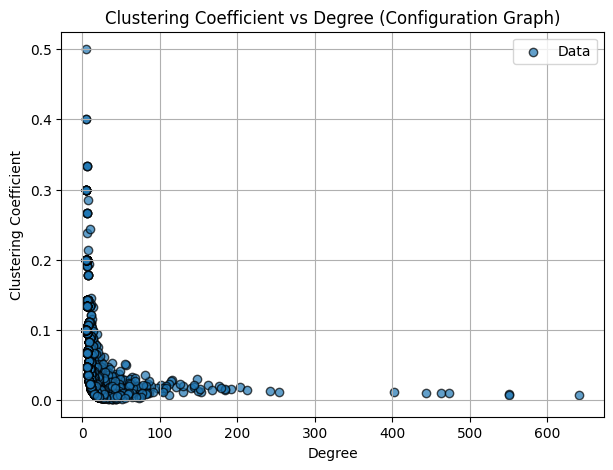

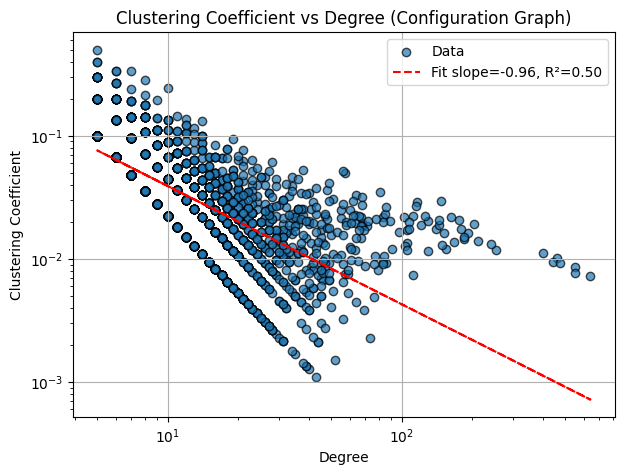

In [43]:
# Plot Clustering Coefficient vs Degree
plot_metric_vs_degree(holme_kim_degrees, holme_kim_clustering_values, "Holme-Kim Graph", "Clustering Coefficient", loglog=False)
plot_metric_vs_degree(holme_kim_degrees, holme_kim_clustering_values, "Holme-Kim Graph", "Clustering Coefficient", loglog=True)

plot_metric_vs_degree(config_degrees, config_clustering_values, "Configuration Graph", "Clustering Coefficient", loglog=False)
plot_metric_vs_degree(config_degrees, config_clustering_values, "Configuration Graph", "Clustering Coefficient", loglog=True)


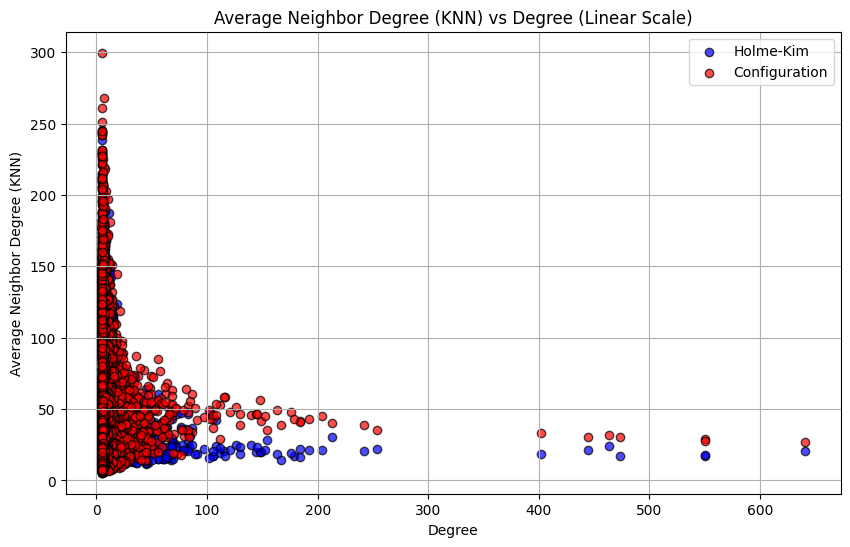

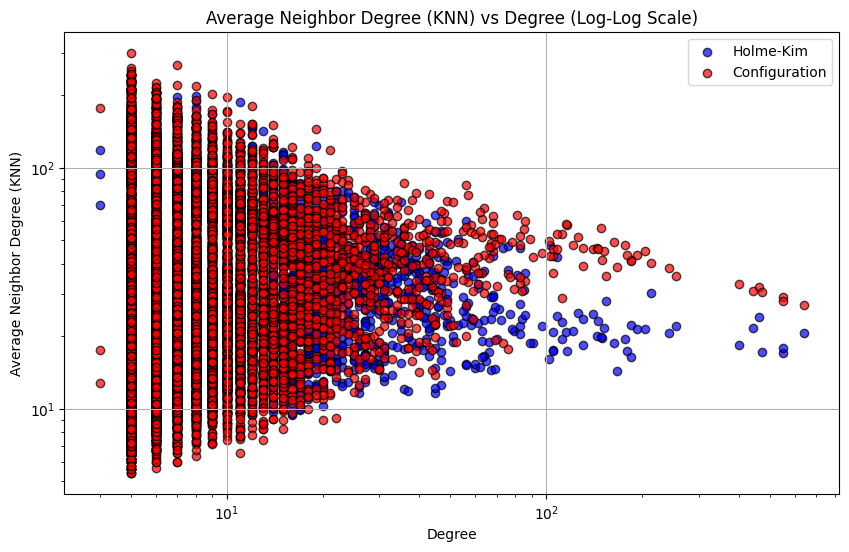

In [44]:
# Plot KNN (Average Neighbor Degree) vs Degree
plot_combined_metrics_vs_degree(
    holme_kim_degrees, holme_kim_knn_values, "Holme-Kim",
    "Average Neighbor Degree (KNN)",
    config_degrees, config_knn_values, "Configuration",
    loglog=False
)

plot_combined_metrics_vs_degree(
    holme_kim_degrees, holme_kim_knn_values, "Holme-Kim",
    "Average Neighbor Degree (KNN)",
    config_degrees, config_knn_values, "Configuration",
    loglog=True
)

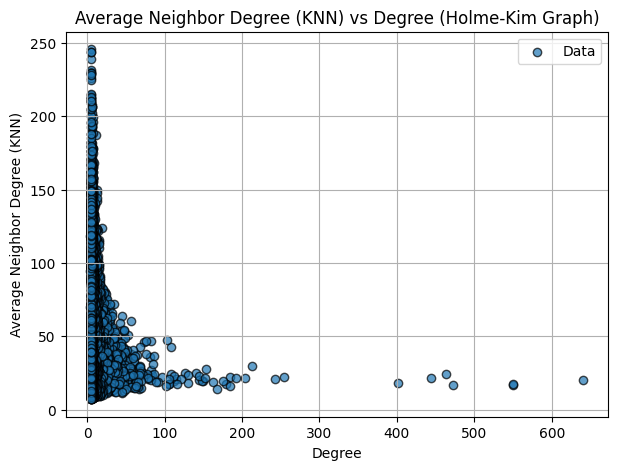

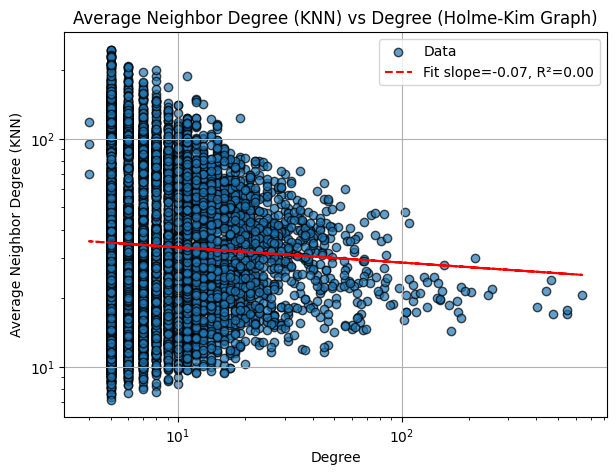

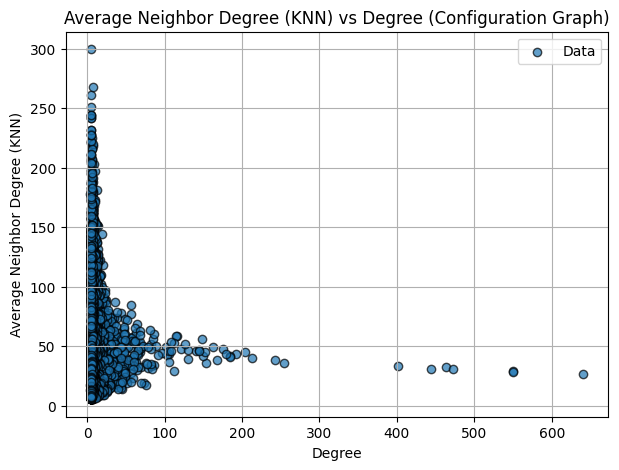

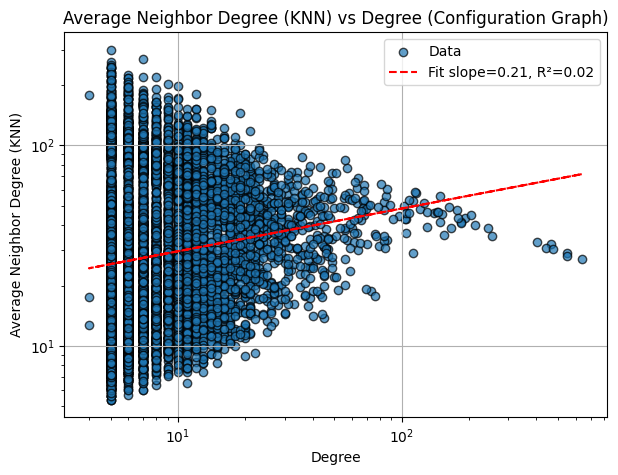

In [45]:
# Plot KNN (Average Neighbor Degree) vs Degree
plot_metric_vs_degree(holme_kim_degrees, holme_kim_knn_values, "Holme-Kim Graph", "Average Neighbor Degree (KNN)", loglog=False)
plot_metric_vs_degree(holme_kim_degrees, holme_kim_knn_values, "Holme-Kim Graph", "Average Neighbor Degree (KNN)", loglog=True)

plot_metric_vs_degree(config_degrees, config_knn_values, "Configuration Graph", "Average Neighbor Degree (KNN)", loglog=False)
plot_metric_vs_degree(config_degrees, config_knn_values, "Configuration Graph", "Average Neighbor Degree (KNN)", loglog=True)


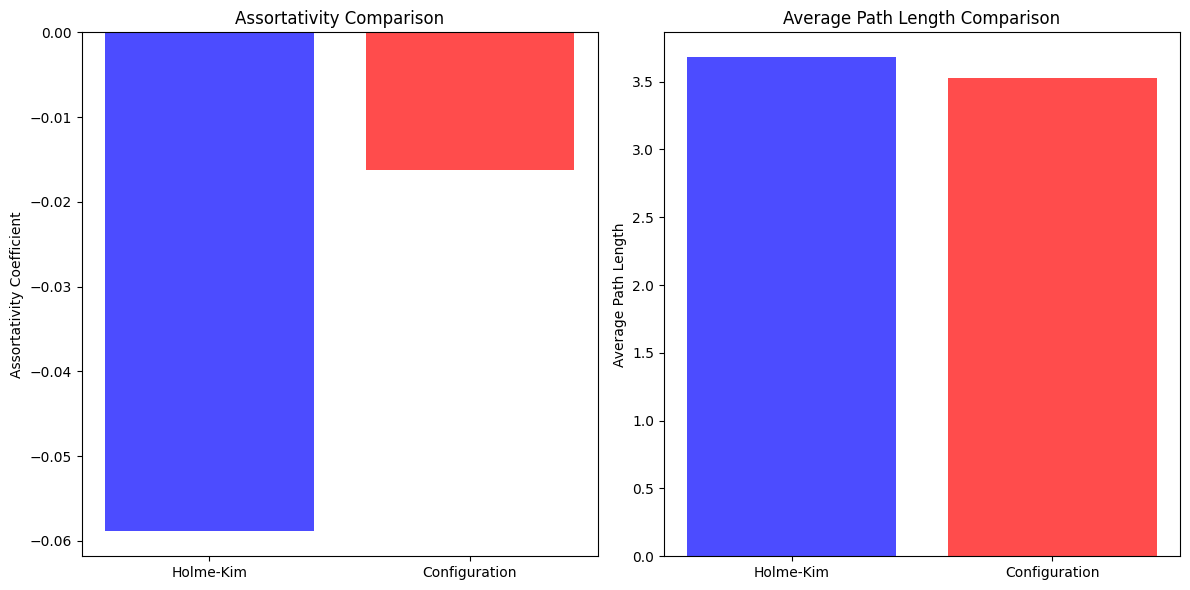

In [46]:
# Calculate metrics
hk_assortativity = nx.degree_assortativity_coefficient(holme_kim_graph)
conf_assortativity = nx.degree_assortativity_coefficient(configuration_graph)

hk_avg_path_length = nx.average_shortest_path_length(holme_kim_graph) if nx.is_connected(holme_kim_graph) else None
conf_avg_path_length = nx.average_shortest_path_length(configuration_graph) if nx.is_connected(configuration_graph) else None

# Define plot function
def plot_assortativity_and_path_length(assort1, assort2, avg_path1, avg_path2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    ax1.bar(["Holme-Kim", "Configuration"], [assort1, assort2], color=["blue", "red"], alpha=0.7)
    ax1.set_title("Assortativity Comparison")
    ax1.set_ylabel("Assortativity Coefficient")

    ax2.bar(["Holme-Kim", "Configuration"], [avg_path1, avg_path2], color=["blue", "red"], alpha=0.7)
    ax2.set_title("Average Path Length Comparison")
    ax2.set_ylabel("Average Path Length")

    plt.tight_layout()
    plt.show()

# Call for visualization if values are valid
if hk_assortativity is not None and conf_assortativity is not None and hk_avg_path_length is not None and conf_avg_path_length is not None:
    plot_assortativity_and_path_length(hk_assortativity, conf_assortativity, hk_avg_path_length, conf_avg_path_length)
else:
    print("One or more metrics could not be calculated.")


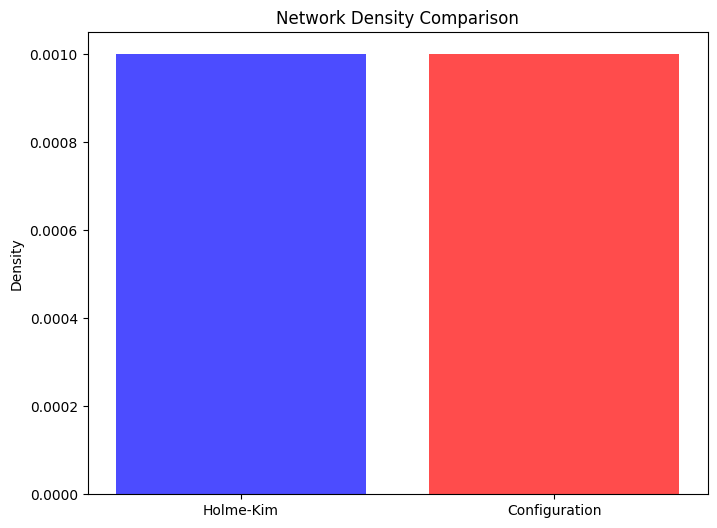

In [47]:
def plot_density_comparison(graph1, label1, graph2, label2):
    density1 = nx.density(graph1)
    density2 = nx.density(graph2)

    plt.figure(figsize=(8, 6))
    plt.bar([label1, label2], [density1, density2], color=['blue', 'red'], alpha=0.7)
    plt.ylabel("Density")
    plt.title("Network Density Comparison")
    plt.show()

# Call for density comparison
plot_density_comparison(holme_kim_graph, "Holme-Kim", configuration_graph, "Configuration")


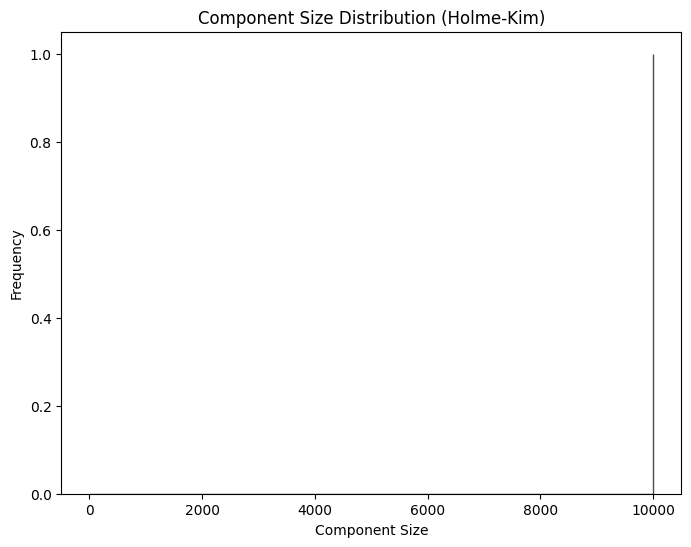

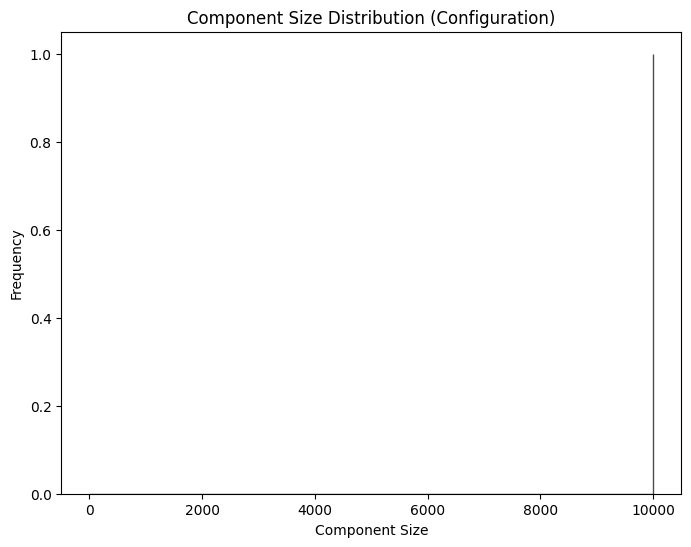

In [48]:
def plot_component_size_distribution(graph, label):
    component_sizes = [len(c) for c in nx.connected_components(graph)]

    plt.figure(figsize=(8, 6))
    plt.hist(component_sizes, bins=range(1, max(component_sizes) + 1), alpha=0.7, color='blue', edgecolor='black')
    plt.xlabel("Component Size")
    plt.ylabel("Frequency")
    plt.title(f"Component Size Distribution ({label})")
    plt.show()

# Call for both graphs
plot_component_size_distribution(holme_kim_graph, "Holme-Kim")
plot_component_size_distribution(configuration_graph, "Configuration")


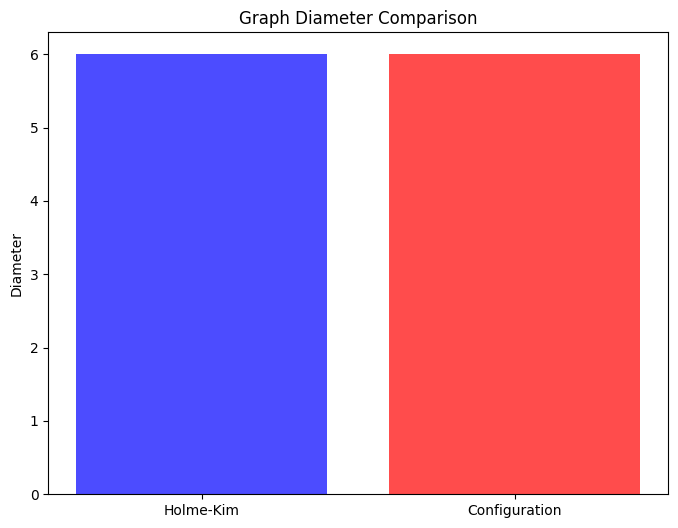

In [49]:
def plot_diameter_comparison(graph1, label1, graph2, label2):
    if nx.is_connected(graph1) and nx.is_connected(graph2):
        diameter1 = nx.diameter(graph1)
        diameter2 = nx.diameter(graph2)

        plt.figure(figsize=(8, 6))
        plt.bar([label1, label2], [diameter1, diameter2], color=['blue', 'red'], alpha=0.7)
        plt.ylabel("Diameter")
        plt.title("Graph Diameter Comparison")
        plt.show()
    else:
        print("One of the graphs is not connected; diameter comparison is not possible.")

# Call for both graphs
plot_diameter_comparison(holme_kim_graph, "Holme-Kim", configuration_graph, "Configuration")


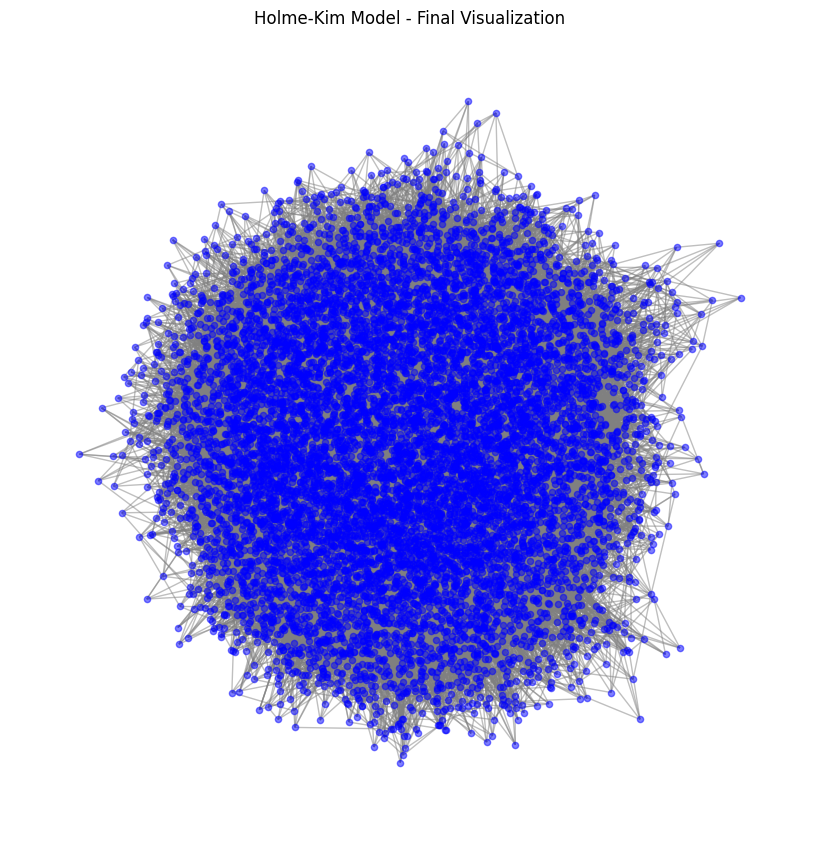

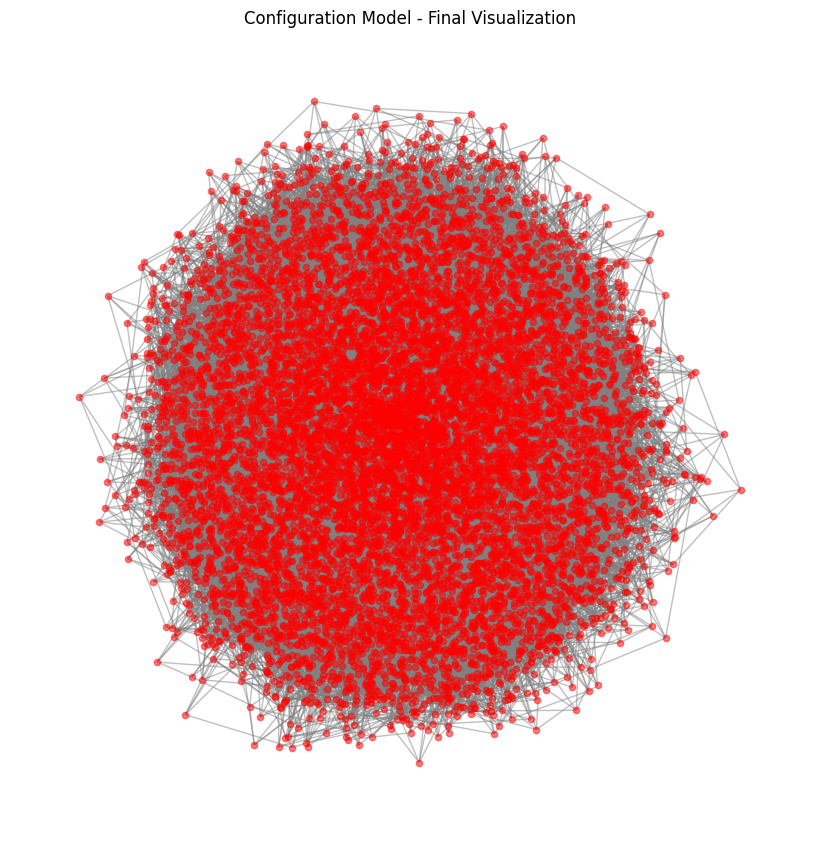

In [50]:
# Final Graph Visualizations
plt.figure(figsize=(8, 8))
nx.draw_spring(holme_kim_graph, node_size=20, node_color="blue", edge_color="gray", alpha=0.5)
plt.title("Holme-Kim Model - Final Visualization")
plt.show()

plt.figure(figsize=(8, 8))
nx.draw_spring(configuration_graph, node_size=20, node_color="red", edge_color="gray", alpha=0.5)
plt.title("Configuration Model - Final Visualization")
plt.show()